<a href="https://colab.research.google.com/github/stefisha/Cat-Vision/blob/main/cat_breeed_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow import keras
from keras.layers import *
from keras.models import Model
from keras.applications import MobileNetV2

In [15]:
import os
import pathlib
import datetime
from glob import glob
from PIL import Image

After the imports we need to load the data. Since all the images are in seperate folders, we need to check if there are any problematic ones.

In [16]:
PATH = r'C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Classification\Data\Gano-Cat-Breeds-V1_1'


Now we can load all the images, we put them into a dataset containing filepaths and labels, excluding the one problematic image.

In [17]:
import pathlib
import os
import pandas as pd

def make_dataFrame(data):
    path = pathlib.Path(data)
    filepaths = list(path.glob(r"*/*.*"))  # This will now capture all files
    # Filter out non-image files and the problematic image
    filepaths = [filepath for filepath in filepaths if filepath.suffix.lower() in ['.jpg', '.png', '.jpeg', '.bmp', '.gif']
                 and str(filepath) != r'C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Classification\Data\Gano-Cat-Breeds-V1_1\American Bobtail\AmericanBobtail-33999199_1891.jpg']
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
    d1 = pd.Series(filepaths, name='filepaths').astype(str)
    d2 = pd.Series(labels, name='labels')
    df = pd.concat([d1, d2], axis=1)
    return df


In [18]:
dataset = make_dataFrame(PATH)
dataset

,filepaths,labels
0,C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...,Abyssinian
1,C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...,Abyssinian
2,C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...,Abyssinian
3,C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...,Abyssinian
4,C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...,Abyssinian
...,...,...
5619,C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...,Tuxedo
5620,C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...,Tuxedo
5621,C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...,Tuxedo
5622,C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...,Tuxedo


In [19]:
class_names = dataset['labels'].unique()
class_names

array(['Abyssinian', 'American Bobtail', 'American Shorthair', 'Bengal',
       'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau',
       'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese',
       'Sphynx', 'Tuxedo'], dtype=object)

In [20]:
print(dataset.describe())
print(dataset.head())

                                                filepaths      labels
count                                                5624        5624
unique                                               5624          15
top     C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...  Abyssinian
freq                                                    1         375
                                           filepaths      labels
0  C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...  Abyssinian
1  C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...  Abyssinian
2  C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...  Abyssinian
3  C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...  Abyssinian
4  C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Class...  Abyssinian


Looking at this, we can see there are 5624 different filepaths (meaning 5624 different images) and 15 different breeds.

Let's figure out how many images there are of each breed.

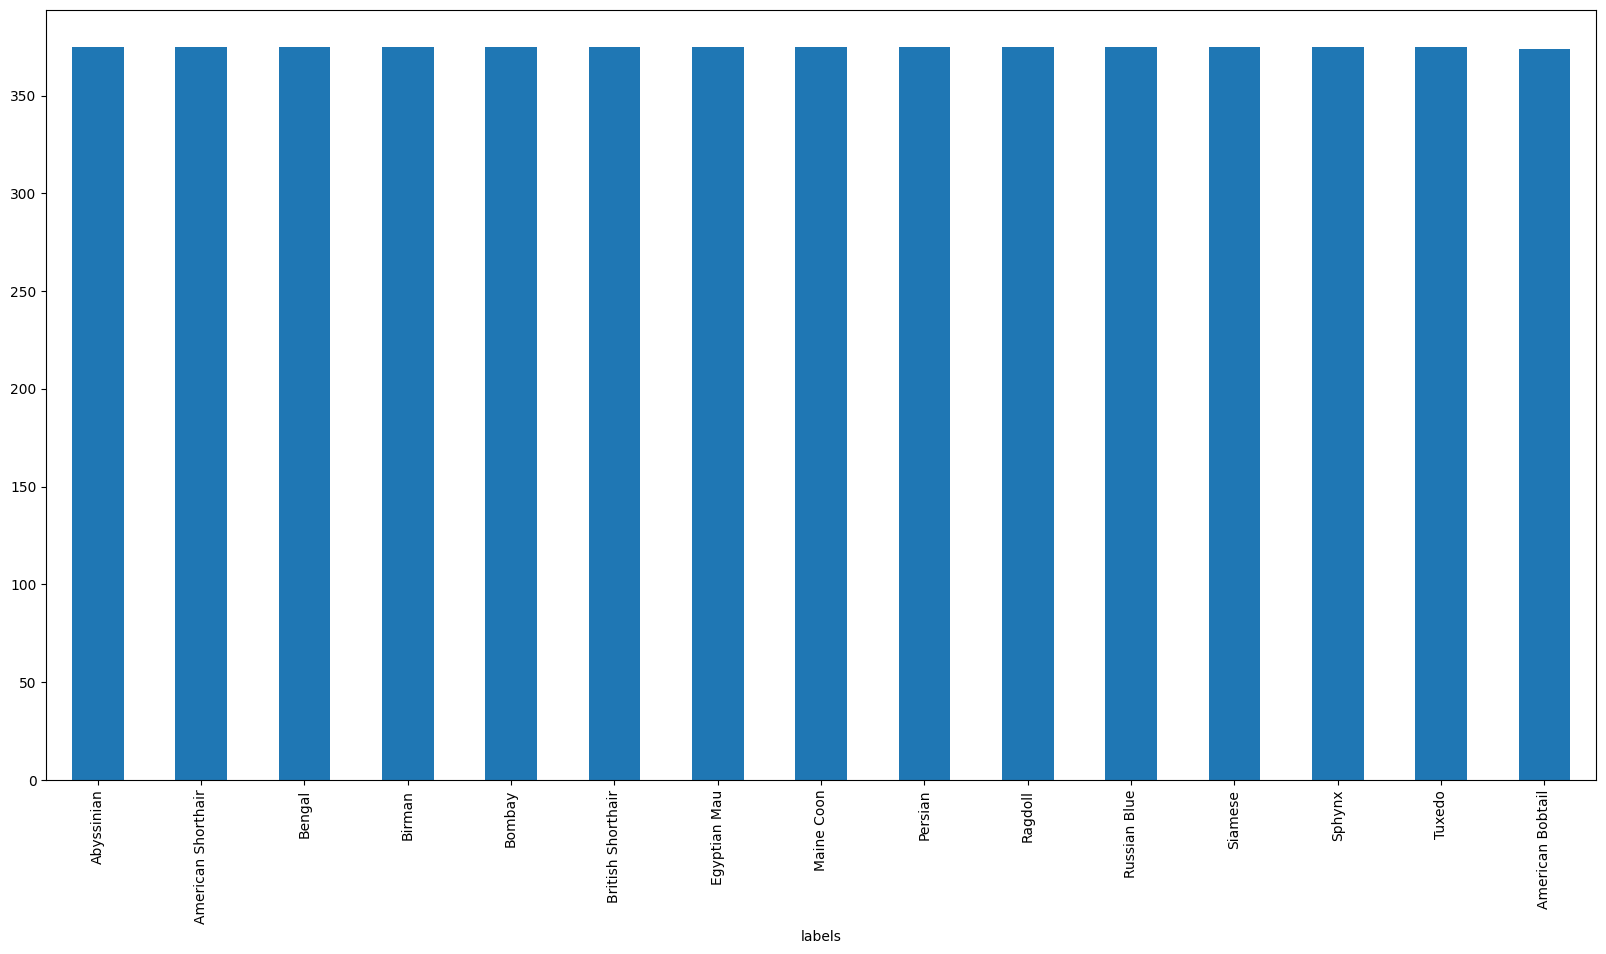

In [21]:
dataset['labels'].value_counts().plot.bar(figsize=(20,10));

It appears that there is an equal amount of images for each race, which is good as our model will be able to learn properly. If there was a substantionaly larger amount of samples for one breed, the model would become really good at detecting just that one breed, at the expense of the others. Conversely, if one breed was very unrepresented, the model would most likely not be able to recognize it correctly.

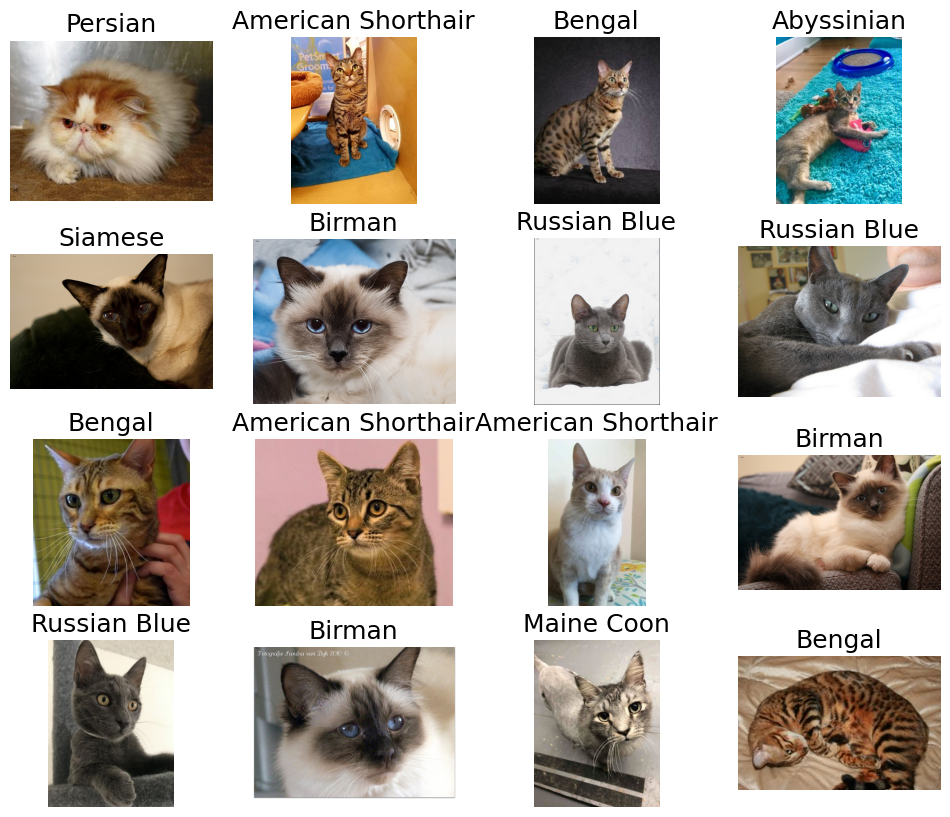

In [22]:
# Visualize some images and breeds
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,10))
for i,ax in enumerate(axes.flat):
    idx = np.random.randint(1,5624)
    x = plt.imread(dataset.iloc[idx]['filepaths'])
    ax.imshow(x)
    ax.set_title(dataset['labels'][idx], fontsize=18)
    ax.set_axis_off()
plt.show()

In [23]:
train_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

In [24]:
train_dataset = train_generator.flow_from_dataframe(dataframe=dataset,
                                                    x_col='filepaths',
                                                    y_col='labels',
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='training',
                                                    shuffle=True)

Found 5624 validated image filenames belonging to 15 classes.


In [25]:
# Load MobileNetV2 base model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

# Add custom top layers
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

# Create the model
model = Model(inputs, outputs)


In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,775 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [27]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
history = model.fit(train_dataset,
          epochs=20,
          callbacks=[keras.callbacks.EarlyStopping(monitor='accuracy',
                                                  mode='max',
                                                  patience=3)])

Epoch 1/20


c:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 93s 497ms/step - accuracy: 0.4149 - loss: 1.8669
Epoch 2/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 492ms/step - accuracy: 0.6844 - loss: 0.9422
Epoch 3/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 88s 495ms/step - accuracy: 0.7208 - loss: 0.8101
Epoch 4/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 493ms/step - accuracy: 0.7427 - loss: 0.7317
Epoch 5/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 88s 496ms/step - accuracy: 0.7617 - loss: 0.6851
Epoch 6/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 491ms/step - accuracy: 0.7834 - loss: 0.6398
Epoch 7/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 493ms/step - accuracy: 0.7911 - loss: 0.5923
Epoch 8/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 88s 496ms/step - accuracy: 0.7900 - loss: 0.5583
Epoch 9/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 88s 498ms/step - accuracy: 0.8061 - loss: 0.5313
Epoch 10/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 491ms/step - accuracy: 0.8312 - loss: 0.4795
Epoch 11/20
176/176 ━━━━━━━━━━━━━━━━━━━━ 87s 490ms/step - accuracy: 0.8196 - loss: 0.4928
Epoch 12/20
176/176 ━━━━━━━━━━

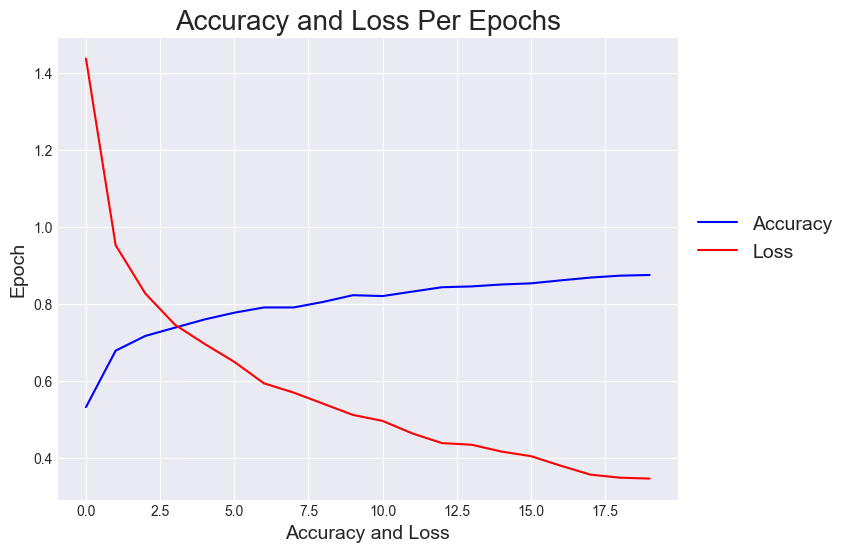

In [29]:
sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'],c='blue')
plt.plot(history.history['loss'],c='red')
plt.title("Accuracy and Loss Per Epochs", fontsize=20)
plt.xlabel("Accuracy and Loss", fontsize=14)
plt.ylabel("Epoch", fontsize=14)
plt.legend(["Accuracy","Loss"], fontsize=14,loc=[1.02,0.5])
plt.show();

In [30]:
def predict_cat_breed(image, model):
    img = keras.preprocessing.image.load_img(image)
    img_arr = keras.utils.img_to_array(img)
    img_arr = img_arr/255.
    img_arr = tf.image.resize(img_arr,[224,224])
    pred = np.argmax(model.predict(np.expand_dims(img_arr, axis=0)))
    prediction = class_names[pred]

    plt.figure(figsize=(2,2), dpi=200)
    plt.imshow(img)
    plt.title(prediction, fontsize=12)
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
The predicted cat breed is: Birman


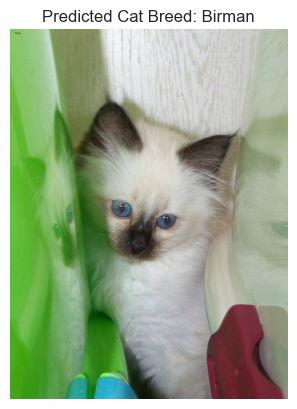

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define the path to your image
image_path = r'C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Classification\Data\Gano-Cat-Breeds-V1_1\Birman\Birman_1.jpg'

# List of cat breeds
cat_breeds = [
    "Abyssinian", "American Bobtail", "American Shorthair", "Bengal", "Birman", "Bombay",
    "British Shorthair", "Egyptian Mau", "Maine Coon", "Persian", "Ragdoll", "Russian Blue",
    "Siamese", "Sphynx", "Tuxedo"
]

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Adjust target_size based on your model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create batch axis
    img_array /= 255.0  # Normalize the image array
    return img_array

# Function to predict the cat breed
def predict_cat_breed(image_path, model):
    img_array = load_and_preprocess_image(image_path)
    predictions = model.predict(img_array)
    predicted_class = cat_breeds[np.argmax(predictions)]
    return predicted_class

# Assuming 'model' is already loaded
predicted_breed = predict_cat_breed(image_path, model)
print(f'The predicted cat breed is: {predicted_breed}')

# Display the image
def display_image(image_path):
    img = image.load_img(image_path)
    plt.imshow(img)
    plt.title(f'Predicted Cat Breed: {predicted_breed}')
    plt.axis('off')
    plt.show()

display_image(image_path)


In [33]:
import os
import datetime
import tensorflow as tf

def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (str)
    for clarity and reuse.
    """
    # Create model directory with current time
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    model_dir = os.path.join(r'C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Classification\Data\models', current_time)
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"model-{suffix}.keras")  # save format of model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path

# Example usage
# Assuming 'model' is your trained model and you have a suffix
model_path = save_model(model, suffix="my_model")
print(f"Model saved at: {model_path}")


Saving model to: C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Classification\Data\models\20240608-150210\model-my_model.keras...
Model saved at: C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Classification\Data\models\20240608-150210\model-my_model.keras


In [34]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path)
  return model

In [35]:
# Save our model trained on 1000 images
save_model(model, suffix="cat-vision-imagenet")

Saving model to: C:\Users\HP\OneDrive\Masaüstü\Cat Breeds Classification\Data\models\20240608-150235\model-cat-vision-imagenet.keras...


'C:\\Users\\HP\\OneDrive\\Masaüstü\\Cat Breeds Classification\\Data\\models\\20240608-150235\\model-cat-vision-imagenet.keras'